Let's brainstorm what we want to do.
I want to go 1 neuron at a time.

Find only true entries (there should be 85 unique root id's that have myelin = true)

Start with "tag == t" list.
#go through one by one each row of the list.

Okay, to start, let's do all for this neuron: 
139  864691136021592568           46             25        BC


How to save:
pandas dataframe object.
Columns:
pt_root_id
pt_position
myelin: 1 or 0.
image_unwr: ndarray
image: ndarray
contour_length



In [12]:
import numpy as np
import pandas as pd
import preprocess_images
from caveclient import CAVEclient
import imageryclient as ic
import logging
import urllib3
import matplotlib.pyplot as plt



In [3]:
#suppress warnings with caveclient and urllib3
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

In [5]:
client = CAVEclient('minnie65_public')
client.version = 1412
myelin_df = client.materialize.query_table('vortex_manual_myelination_v0')

Table Owner Notice on vortex_manual_myelination_v0: Myelination status assessed for the axon of the VALID_ID, not the pt_root_id.


In [11]:
#create new dataset
columns = [
    "pt_root_id",
    "pt_position",
    "myelin",
    "image_unwr",
    "image",
    "contour_sm",
    "contour_length"
]

# Create empty DataFrame
manual_myelin_dataset = pd.DataFrame(columns=columns)

In [6]:
#load dataset
manual_myelin_dataset = pd.read_pickle("manual_myelin_dataset.pkl")

In [53]:
img_client = ic.ImageryClient(client=client)
box_sz_microns = 4 # Pick something divisible by 4.

#start with just 1 neuron.

for pt_root_id in [864691135441799752]:

# pt_root_id = 864691136578820884

    #Get all manual myelin entries for this neuron.
    # myelin_neur_df = myelin_df[myelin_df["pt_root_id"] == pt_root_id]

    myelin_neur_df = myelin_df[(myelin_df["pt_root_id"] == pt_root_id) & (myelin_df["tag"] == "f")]


    #Get the skeleton for this neuron.
    sk_df = client.skeleton.get_skeleton(pt_root_id, output_format='swc')

    count = 0
    for idx, row in myelin_neur_df.iterrows():
        print(idx)
        count += 1
        if count < 250:
            continue
        if count > 1000:
            break
        

        ctr = row["pt_position"]
        tag = row["tag"]

        # Check if entry already exists
        already_in = manual_myelin_dataset[
            (manual_myelin_dataset["pt_root_id"] == pt_root_id) &
            (manual_myelin_dataset["pt_position"].apply(lambda x: np.array_equal(x, ctr)))
        ]
        if not already_in.empty:
            continue

        plane = preprocess_images.pick_normal_plane(ctr, sk_df)
        [image,segs] = preprocess_images.pull_image_and_segmentation(img_client, ctr, pt_root_id, plane, box_sz_microns)
        [image_unwr, contour_sm] = preprocess_images.unwrap_image_along_boundary(image, segs)

        #add to dataset
        new_row = pd.DataFrame([{
            "pt_root_id": pt_root_id,
            "pt_position": ctr,
            "myelin": tag,
            "image_unwr": image_unwr,
            "image": image,
            "contour_sm": contour_sm,
            "contour_length": len(contour_sm)
        }])
        manual_myelin_dataset = pd.concat([manual_myelin_dataset, new_row], ignore_index=True)



490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
548
784
785
786
787
788
1770
2005
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
3291
3912
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
514

ValueError: min() arg is an empty sequence

In [58]:
#save dataset
manual_myelin_dataset.to_pickle("manual_myelin_dataset.pkl")

In [7]:
len(manual_myelin_dataset)
# len(myelin_neur_df)

17464

In [57]:
len(manual_myelin_dataset[manual_myelin_dataset["myelin"] == "t"])
# myelin_df.iloc[21934]

2612

In [48]:
# manual_myelin_dataset[manual_myelin_dataset["pt_root_id"] == 864691135970572133].iloc[3024:3050]

,pt_root_id,pt_position,myelin,image_unwr,image,contour_sm,contour_length
15976,864691135970572133,"[196008, 194930, 23370]",f,"[[143.87206571867952, 130.13551521167685, 129....","[[134.2, 122.2, 128.8, 132.6, 119.0, 131.4, 13...","[[51.71528646757606, 48.84745937013983], [51.5...",29
15977,864691135970572133,"[196414, 195156, 23389]",f,"[[125.2407884075363, 126.18122415533698, 126.0...","[[134.8, 131.4, 136.0, 128.4, 128.4, 125.0, 13...","[[51.61717565994613, 48.97453653095269], [51.4...",27
15978,864691135970572133,"[196626, 195270, 23395]",f,"[[122.34261857623524, 140.27978281182868, 140....","[[148.4, 136.6, 140.4, 128.8, 130.6, 137.4, 13...","[[50.956890655845726, 50.60973826524346], [50....",23
15979,864691135970572133,"[196824, 195390, 23405]",f,"[[134.4750192583968, 130.85237558771837, 130.8...","[[136.2, 129.8, 137.8, 133.4, 148.2, 137.0, 12...","[[53.30069128133257, 50.26180523893188], [53.2...",27
15980,864691135970572133,"[197216, 195644, 23423]",f,"[[120.27926746144405, 126.18675175283606, 132....","[[124.8, 126.6, 119.6, 109.6, 109.0, 115.8, 11...","[[54.49793379958763, 53.06451810933404], [54.4...",53
15981,864691135970572133,"[197392, 195812, 23421]",f,"[[133.64392659510963, 127.25642470469137, 127....","[[146.8, 144.8, 133.4, 136.4, 138.6, 133.4, 12...","[[63.409963351297485, 55.16359455675764], [63....",71
15982,864691135970572133,"[197842, 195986, 23420]",f,"[[131.21341581793243, 129.6803759999083, 127.9...","[[128.2, 124.2, 130.2, 128.0, 119.2, 134.0, 13...","[[54.13110958102596, 47.46148151835323], [54.0...",27
15983,864691135970572133,"[198536, 196212, 23406]",f,"[[143.71862588190305, 126.25110638893324, 125....","[[128.6, 122.2, 122.8, 125.0, 121.8, 118.4, 12...","[[52.988924339466706, 48.57357218079774], [52....",49
15984,864691135970572133,"[198730, 196314, 23394]",f,"[[126.93397905682282, 133.27998779073693, 133....","[[127.0, 125.6, 128.0, 132.4, 135.6, 127.6, 13...","[[53.93445479571357, 51.6291699504827], [53.83...",41
15985,864691135970572133,"[198930, 196400, 23382]",f,"[[141.25686256408025, 125.3306103178432, 128.7...","[[115.0, 120.8, 113.6, 130.2, 142.4, 142.2, 13...","[[52.96924903803323, 47.665579651122655], [52....",35


In [22]:
#test
sk_df = client.skeleton.get_skeleton(864691135868814358, output_format='swc')
ctr = [179104, 192840, 18470]
plane = preprocess_images.pick_normal_plane(ctr, sk_df)
print(plane)

xz


In [23]:
#test
 #convert sk_df from micron coordinates to voxel coordinates.
sk_df_vx = sk_df.copy()
sk_df_vx['x'] = sk_df_vx['x']*1000 // 4
sk_df_vx['y'] = sk_df_vx['y']*1000 // 4
sk_df_vx['z'] = sk_df_vx['z']*1000 // 40

# Compute distances to all points in the skeleton DataFrame
distances = np.sqrt(
    (sk_df_vx['x'] - ctr[0])**2 +
    (sk_df_vx['y'] - ctr[1])**2 +
    (sk_df_vx['z'] - ctr[2])**2
)

#get plane perpendicular to axon
closest_idx = distances.idxmin() #Find index of closest point
parent_idx = sk_df.loc[closest_idx, 'parent'] #Get parent index of that point
vector_diff = sk_df_vx.loc[closest_idx, ['x', 'y', 'z']].values - sk_df_vx.loc[parent_idx, ['x', 'y', 'z']].values

#Scale z to match x and y:
vector_diff[0:2] *= 4  # Convert x and y to nanometers
vector_diff[2] *= 40  # Convert z to nanometers

print(sk_df_vx.loc[closest_idx, ['x', 'y', 'z']].values)
print(sk_df_vx.loc[parent_idx, ['x', 'y', 'z']].values)
print(vector_diff)

max_dim = np.argmax(np.abs(vector_diff)) #find the dimension with the largest difference
possible_planes = ['yz','xz','xy']
plane = possible_planes[max_dim]
print(plane)

[179136. 192712.  18433.]
[179142. 192546.  18368.]
[ -24.  664. 2600.]
xy


In [10]:
manual_myelin_dataset.iloc[539:543]

,pt_root_id,pt_position,myelin,image_unwr,image,contour_sm,contour_length
539,864691135868814358,"[179104, 192840, 18470]",t,"[[139.13117229053643, 134.12647446715113, 129....","[[128.4, 126.0, 132.0, 123.4, 123.0, 131.4, 12...","[[57.37177156142536, 53.219602089336476], [57....",87
540,864691135868814358,"[178768, 193320, 18561]",t,"[[128.56663500716286, 126.6783916315591, 127.6...","[[140.6, 127.8, 140.0, 134.8, 135.4, 126.2, 12...","[[39.64254234509762, 97.2049942540193], [39.68...",227
541,864691135868814358,"[178664, 193352, 18592]",t,"[[129.61819240359955, 135.8569584640833, 137.1...","[[136.6, 136.2, 138.6, 137.2, 128.2, 130.2, 13...","[[57.99004701770342, 1.427595108781747], [57.8...",275
542,864691135868814358,"[179040, 192992, 18497]",t,"[[135.0149127389448, 129.0884142926795, 127.36...","[[131.8, 138.6, 132.8, 132.2, 137.4, 128.4, 12...","[[59.27675905421016, 43.285692854711506], [59....",83


In [8]:
#Now, I want to manually check entries in the dataset.
#select all entries with myelin = t

data_true = manual_myelin_dataset[manual_myelin_dataset["myelin"] == "t"]
cc = 3

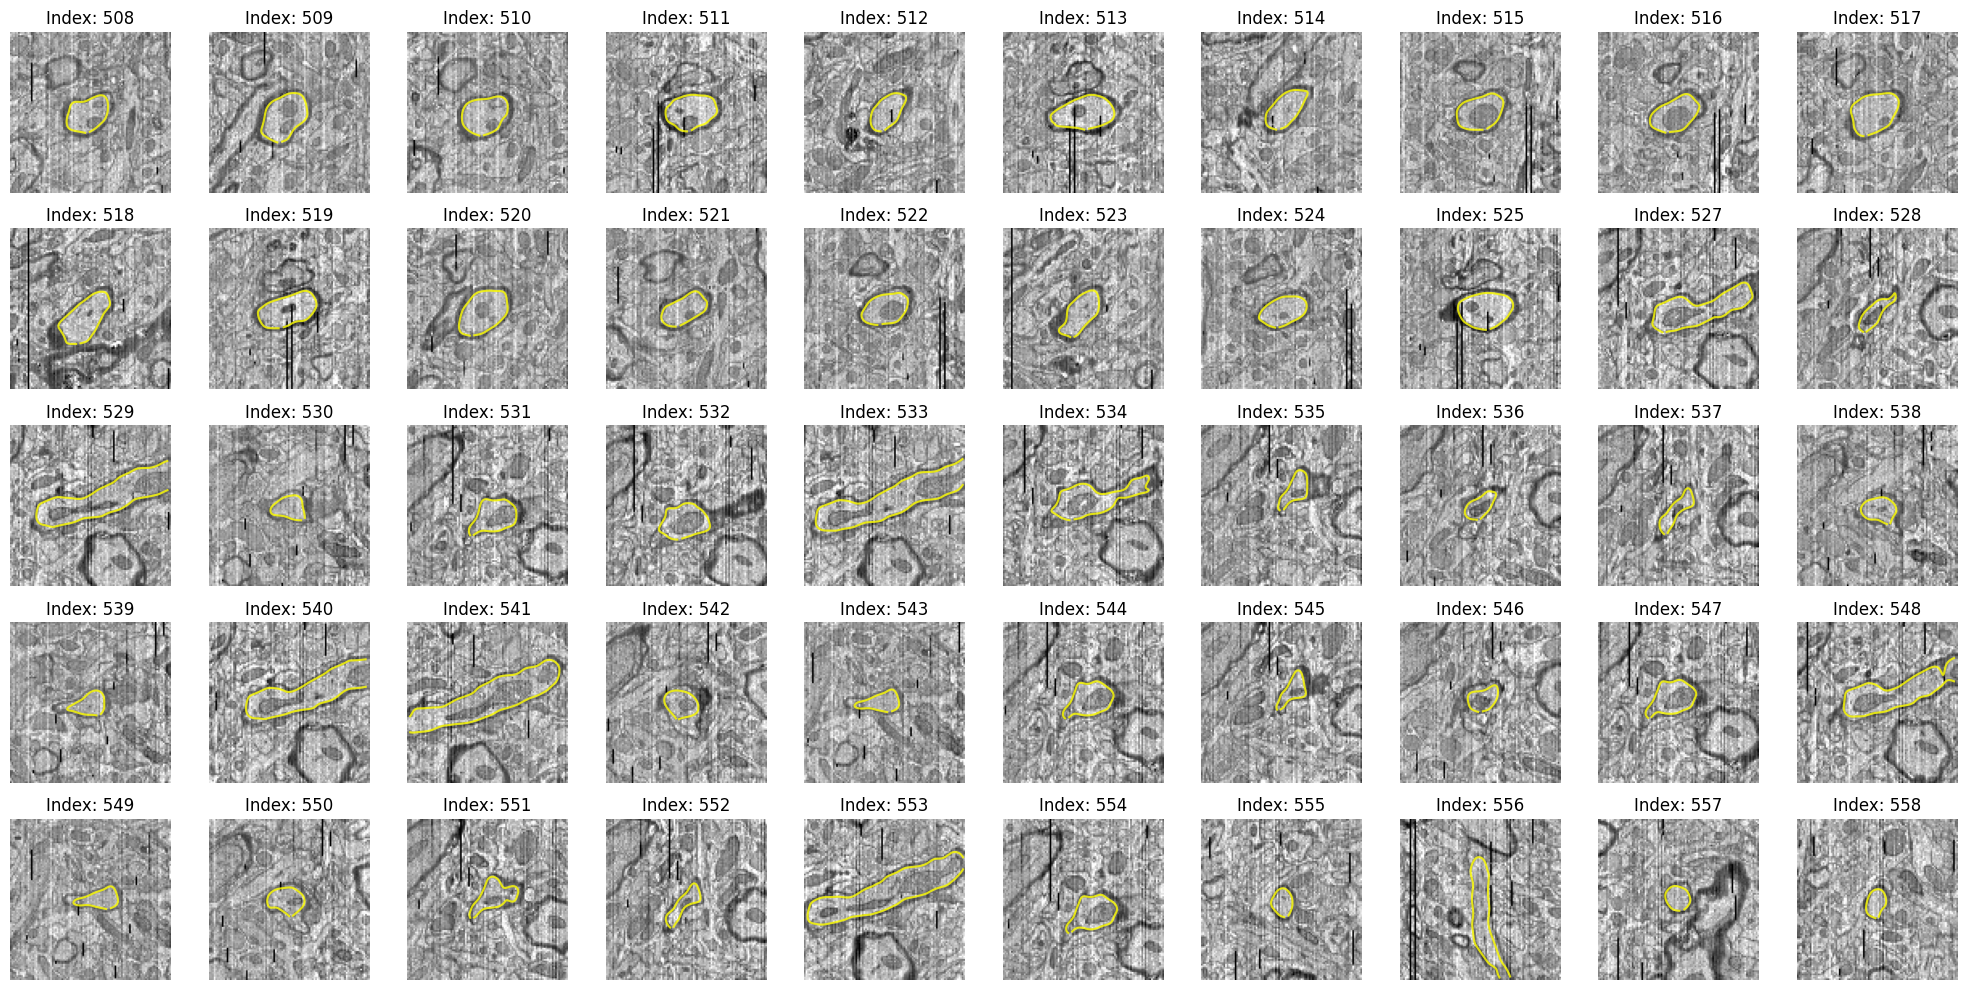

In [9]:
cc += 1

counter = cc*50
# Display the first 50 entries, from the "image" field in a subplot with each subplot having the original DataFrame index as its caption

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
for ax in axes.flatten():
    if counter < len(data_true):
        row = data_true.iloc[counter]
        img = row["image"]
        contour_sm = row["contour_sm"]
        original_idx = data_true.index[counter]  # Get the original DataFrame index

        ax.imshow(img, cmap="gray", vmin=100, vmax=150)
        ax.plot(contour_sm[:, 1], contour_sm[:, 0], color='yellow', alpha=0.8, linewidth=1.5)
        ax.set_title(f"Index: {original_idx}")
        ax.axis("off")
        counter += 1
plt.tight_layout()
plt.show()



In [102]:
print(np.min(data_true["image"].iloc[0]))

39.2


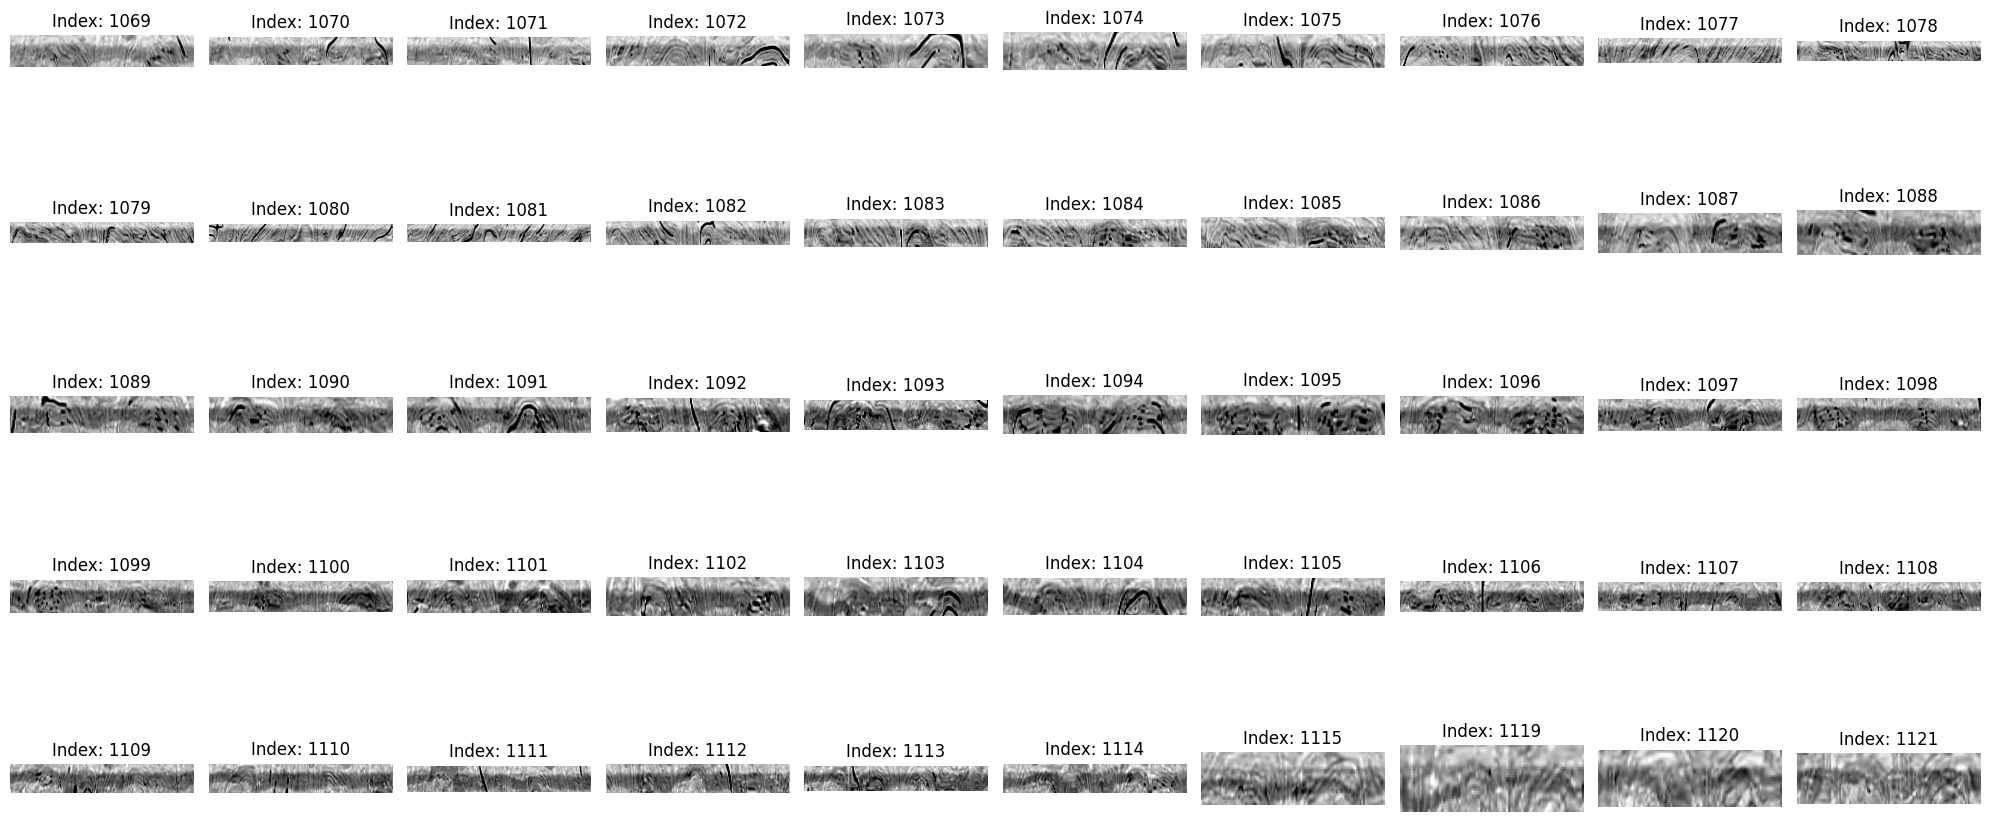

In [141]:
#get unwrapped

counter = cc*50
# Display the first 50 entries, from the "image" field in a subplot with each subplot having the original DataFrame index as its caption

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
for ax in axes.flatten():
    if counter < len(data_true):
        row = data_true.iloc[counter]
        img = row["image_unwr"]
        contour_sm = row["contour_sm"]
        original_idx = data_true.index[counter]  # Get the original DataFrame index

        ax.imshow(img, cmap="gray", vmin=100, vmax=150)
        # ax.plot(contour_sm[:, 1], contour_sm[:, 0], color='yellow', alpha=0.8, linewidth=1.5)
        ax.set_title(f"Index: {original_idx}")
        ax.axis("off")
        counter += 1
plt.tight_layout()
plt.show()

